# In this project I'll use SQL to solve some business question using the skills I've learned before multiply.

First to see what files are included in this project.

In [1]:
!ls -l

total 2316
-rwxrwxrwx 1 dq dq  247205 Apr 20 02:37 Basics.ipynb
-rwxr-xr-x 1 dq dq 1060864 Apr 18 11:38 chinook.db
-rwxr-xr-x 1 dq dq 1060864 Apr 18 11:37 chinook-unmodified.db


To start,I'll define two functions to make sql command easily be executed.

In [2]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

%matplotlib inline

In [3]:
def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q,conn)
    
def run_command(c):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(c)
        
def show_tables():
    q='''SELECT
              name,
              type
         FROM sqlite_master
         WHERE type IN ('table','view')
      '''
    return run_query(q)

In [4]:
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


Here I run the show_tables() to make sure the functions I wrote working well.

## I'm going to write a query that returns each genre, with the number of tracks sold in the USA

In [5]:
q1='''
WITH usa_sold AS
    (
    SELECT c.customer_id,i.invoice_id,t.genre_id
    FROM customer c 
    INNER JOIN invoice i ON c.customer_id=i.customer_id
    INNER JOIN invoice_line il ON i.invoice_id=il.invoice_id
    INNER JOIN track t ON il.track_id=t.track_id
    WHERE c.country='USA'
    )

SELECT 
    g.name genre_name,
    COUNT(us.invoice_id) tracks_sold,
    CAST(COUNT(us.invoice_id) AS float)/CAST(
                                            (
                                            SELECT COUNT(*)
                                            FROM usa_sold
                                            ) AS float) genre_per
FROM genre g
LEFT JOIN usa_sold us ON g.genre_id=us.genre_id
GROUP BY 1
ORDER BY 2 DESC
'''

run_query(q1)

,genre_name,tracks_sold,genre_per
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Latin,22,0.020932
7,Pop,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


In [6]:
data_genre = run_query(q1)
data_genre.set_index('genre_name',inplace=True)
data_genre

,tracks_sold,genre_per
genre_name,,
Rock,561,0.533777
Alternative & Punk,130,0.123692
Metal,124,0.117983
R&B/Soul,53,0.050428
Blues,36,0.034253
Alternative,35,0.033302
Latin,22,0.020932
Pop,22,0.020932
Hip Hop/Rap,20,0.019029


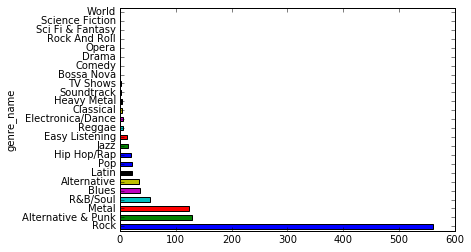

In [7]:
data_genre['tracks_sold'].plot.barh()

Above the picture shown, the rock genre has great larger purchases than any others.For the four artists showed in this project, the one has the punk genre can be a good choice as the punk genre is the second largest purchased one.

## I'm going to analyze the purchases of customers belonging to each employee to see if any sales support agent is performing either better or worse than the others

In [8]:
q2='''
WITH sup_cus AS
    (
    SELECT 
        e.first_name||' '||e.last_name full_name,
        e.title title,
        e.birthdate birthdate,
        e.hire_date hire_date,
        e.city city,
        e.country country,
        c.customer_id customer_id
    FROM employee e
    INNER JOIN customer c ON e.employee_id=c.support_rep_id
    )
    
SELECT 
    full_name,
    title,birthdate,
    hire_date,
    city,
    country,
    COUNT(DISTINCT sc.customer_id) customer_num,
    SUM(i.total) total_sale
FROM sup_cus sc
INNER JOIN invoice i ON sc.customer_id=i.customer_id
GROUP BY full_name
ORDER BY total_sale
'''

run_query(q2)

,full_name,title,birthdate,hire_date,city,country,customer_num,total_sale
0,Steve Johnson,Sales Support Agent,1965-03-03 00:00:00,2017-10-17 00:00:00,Calgary,Canada,18,1393.92
1,Margaret Park,Sales Support Agent,1947-09-19 00:00:00,2017-05-03 00:00:00,Calgary,Canada,20,1584.00
2,Jane Peacock,Sales Support Agent,1973-08-29 00:00:00,2017-04-01 00:00:00,Calgary,Canada,21,1731.51


In some words, it's amazing to find that there are only 3 employees are hired as the sales support agent in this orgnization. By observing the table above, we can say the more customers a employee has the more total sale. And it is understandable that the one hired later would have less customers, however the Margaret Park seems work not hard as the Jane Peacock.Maybe the reason is that Jane is younger than Margaret and so Jane has more passion on work. 

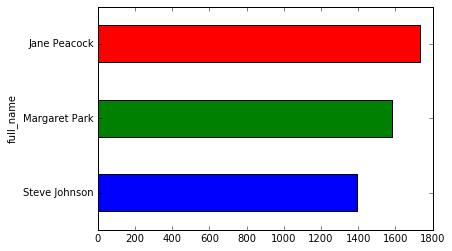

In [9]:
data_employee=run_query(q2)
data_employee.set_index('full_name',inplace=True)
data_employee['total_sale'].plot.barh()

## I'm going to write a query that collates data on purchases from different countries. For each country, include:
* total number of customers
* total value of sales
* average value of sales per customer
* average order value

In [10]:
q3='''
WITH cus_inv AS
    (
    SELECT 
        c.customer_id customer_id,
        c.country country,
        i.invoice_id invoice_id,
        i.total total
    FROM customer c
    INNER JOIN invoice i ON c.customer_id=i.customer_id
    )
SELECT 
    ci.country country,
    COUNT(DISTINCT ci.customer_id) customer_num,
    SUM(ci.total) total_sales,
    SUM(ci.total)/COUNT(DISTINCT ci.customer_id) customer_per_sale,
    SUM(ci.total)/COUNT(ci.invoice_id) invoice_per_sale
FROM cus_inv ci
GROUP BY country
'''

run_query(q3)

,country,customer_num,total_sales,customer_per_sale,invoice_per_sale
0,Argentina,1,39.60,39.600000,7.920000
1,Australia,1,81.18,81.180000,8.118000
2,Austria,1,69.30,69.300000,7.700000
3,Belgium,1,60.39,60.390000,8.627143
4,Brazil,5,427.68,85.536000,7.011148
5,Canada,8,535.59,66.948750,7.047237
6,Chile,1,97.02,97.020000,7.463077
7,Czech Republic,2,273.24,136.620000,9.108000
8,Denmark,1,37.62,37.620000,3.762000
9,Finland,1,79.20,79.200000,7.200000


Next I'll collect the country which has only one customer into an "Other" group.The results would be sorted by the total sales from highest to lowest, with the "Other" group at the very bottom.

In [11]:
q4='''
WITH cus_inv AS
    (
    SELECT 
        c.customer_id customer_id,
        c.country country,
        i.invoice_id invoice_id,
        i.total total
    FROM customer c
    INNER JOIN invoice i ON c.customer_id=i.customer_id
    ),
    cou_cus AS
    (
    SELECT 
        ci.country country,
        COUNT(DISTINCT ci.customer_id) customer_num,
        SUM(ci.total) total_sales,
        COUNT(ci.invoice_id) invoice_num
    FROM cus_inv ci
    GROUP BY country
    ),
    cou_cus_other AS
    (
    SELECT 
        CASE
            WHEN cc.customer_num=1 THEN 'Other'
            ELSE cc.country
        END AS country,
        SUM(cc.customer_num) customer_num,
        SUM(cc.total_sales) total_sales,
        SUM(cc.total_sales)/SUM(cc.customer_num) customer_per_sales,
        SUM(cc.total_sales)/SUM(cc.invoice_num) invoice_per_sales
    FROM cou_cus cc
    GROUP BY 1   
    ORDER BY 4 DESC
    )
SELECT 
    country,
    customer_num,
    total_sales,
    customer_per_sales,
    invoice_per_sales
FROM 
    (
    SELECT 
        cco.*,
        CASE
            WHEN cco.country='Other' THEN 0
            ELSE cco.total_sales
        END AS sort
    FROM cou_cus_other cco
    )
ORDER BY sort DESC   
'''

run_query(q4)

,country,customer_num,total_sales,customer_per_sales,invoice_per_sales
0,USA,13,1040.49,80.037692,7.942672
1,Canada,8,535.59,66.948750,7.047237
2,Brazil,5,427.68,85.536000,7.011148
3,France,5,389.07,77.814000,7.781400
4,Germany,4,334.62,83.655000,8.161463
5,Czech Republic,2,273.24,136.620000,9.108000
6,United Kingdom,3,245.52,81.840000,8.768571
7,Portugal,2,185.13,92.565000,6.383793
8,India,2,183.15,91.575000,8.721429
9,Other,15,1094.94,72.996000,7.448571


In [12]:
data_country=run_query(q4)

## Here I'll make plots to show some information about the differences among the countries.

In [13]:
data_country.set_index('country',inplace=True,drop=True)
data_country

,customer_num,total_sales,customer_per_sales,invoice_per_sales
country,,,,
USA,13,1040.49,80.037692,7.942672
Canada,8,535.59,66.948750,7.047237
Brazil,5,427.68,85.536000,7.011148
France,5,389.07,77.814000,7.781400
Germany,4,334.62,83.655000,8.161463
Czech Republic,2,273.24,136.620000,9.108000
United Kingdom,3,245.52,81.840000,8.768571
Portugal,2,185.13,92.565000,6.383793
India,2,183.15,91.575000,8.721429


In [14]:
colors = [plt.cm.Accent(i) for i in np.linspace(0, 1, data_country.shape[0])]
colors

[(0.49803921580314636, 0.7882353067398071, 0.49803921580314636, 1.0),
 (0.6879354211629606, 0.7068512285456938, 0.7542483737655715, 1.0),
 (0.8778316105113311, 0.7202768332817975, 0.6670357753248775, 1.0),
 (0.9947712421417236, 0.8352941274642945, 0.5503268241882324, 1.0),
 (0.9204306037986978, 0.941222607154472, 0.609196486192591, 1.0),
 (0.29917724115007027, 0.48230680916823565, 0.6809996345463921, 1.0),
 (0.700653597712517, 0.14640523058672733, 0.5620915095011393, 1.0),
 (0.8522568331045263, 0.16935025410105795, 0.3093118041753768, 1.0),
 (0.6682660643960914, 0.36684352965915906, 0.16187620443456324, 1.0),
 (0.4000000059604645, 0.4000000059604645, 0.4000000059604645, 1.0)]

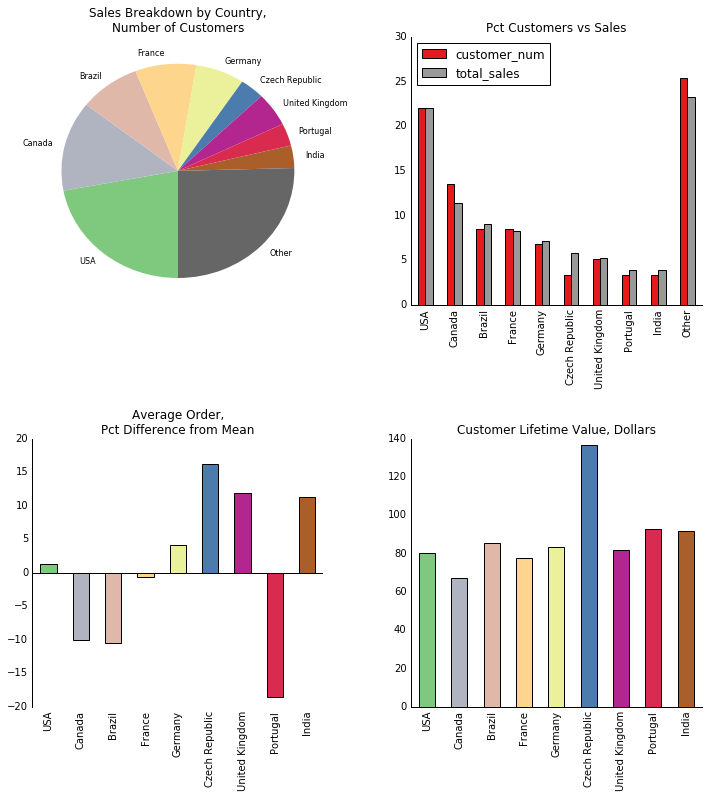

In [15]:
fig=plt.figure(figsize=(12,12))
ax1=fig.add_subplot(2,2,1)
data_country['customer_num'].plot.pie(ax=ax1,
                                      colormap=plt.cm.Accent,
                                      title='Sales Breakdown by Country,\nNumber of Customers',
                                      counterclock=False,
                                      wedgeprops={'linewidth':0},
                                      fontsize=8,
                                      startangle=-90,
                                     )
ax1.set_ylabel('')

ax2=fig.add_subplot(2,2,2)
cvd_cols = ["customer_num","total_sales"]
custs_vs_dollars = data_country[cvd_cols].copy()
custs_vs_dollars.index.name = ''
for c in cvd_cols:
    custs_vs_dollars[c] /= custs_vs_dollars[c].sum() / 100
custs_vs_dollars.plot.bar(
    ax=ax2,
    colormap=plt.cm.Set1,
    title="Pct Customers vs Sales"
)
ax2.tick_params(top="off", right="off", left="off", bottom="off")
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)

ax3=fig.add_subplot(2,2,3)
avg_order = data_country["invoice_per_sales"].copy()
avg_order.index.name = ''
difference_from_avg = avg_order * 100 / avg_order.mean() - 100
difference_from_avg.drop("Other", inplace=True)
difference_from_avg.plot.bar(
    ax=ax3,
    color=colors,
    title="Average Order,\nPct Difference from Mean"
)
ax3.tick_params(top="off", right="off", left="off", bottom="off")
ax3.axhline(0, color='k')
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)
ax3.spines["bottom"].set_visible(False)

ax4=fig.add_subplot(2,2,4)
ltv = data_country["customer_per_sales"].copy()
ltv.index.name = ''
ltv.drop("Other",inplace=True)
ltv.plot.bar(
    ax=ax4,
    color=colors,
    title="Customer Lifetime Value, Dollars"
)
ax4.tick_params(top="off", right="off", left="off", bottom="off")
ax4.spines["top"].set_visible(False)
ax4.spines["right"].set_visible(False)

fig.subplots_adjust(hspace=.5, wspace=.3)
plt.show()

Based on the data, there may be opportunity in the following countries:

* Czech Republic
* United Kingdom
* India

It's worth keeping in mind that because the amount of data from each of these countries is relatively low. Because of this, we should be cautious spending too much money on new marketing campaigns, as the sample size is not large enough to give us high confidence. A better approach would be to run small campaigns in these countries, collecting and analyzing the new customers to make sure that these trends hold with new customers.


## I'm going to write a query that categorizes each invoice as either an album purchase or not, and calculates the following summary statistics:
* Number of invoices
* Percentage of invoices

In [16]:
q5='''
WITH album_track AS
    (
    SELECT a.album_id album_id,t.track_id track_id
    FROM album a
    LEFT JOIN track t ON a.album_id=t.album_id
    ),
    inv_invline_track AS
    (
    SELECT i.invoice_id invoice_id,t.track_id track_id
    FROM invoice i
    LEFT JOIN invoice_line il ON i.invoice_id=il.invoice_id
    LEFT JOIN track t ON il.track_id=t.track_id
    )
    
SELECT 
    i.*,
    CASE
        WHEN  ( 
              ( 
              SELECT at.track_id track_id
              FROM album_track at
              WHERE at.album_id=(
                                 SELECT album_id
                                 FROM inv_invline_track iit
                                 INNER JOIN album_track at ON iit.track_id=at.track_id
                                 WHERE iit.invoice_id=i.invoice_id
                                 LIMIT 1
                                 )                   
              EXCEPT 
              SELECT iit.track_id track_id
              FROM inv_invline_track iit
              WHERE iit.invoice_id = i.invoice_id
              ) IS NULL
              AND 
              (
              SELECT iit.track_id track_id
              FROM inv_invline_track iit
              WHERE iit.invoice_id = i.invoice_id
              EXCEPT
              SELECT at.track_id track_id
              FROM album_track at
              WHERE at.album_id=(
                                 SELECT album_id
                                 FROM inv_invline_track iit
                                 INNER JOIN album_track at ON iit.track_id=at.track_id
                                 WHERE iit.invoice_id=i.invoice_id
                                 LIMIT 1
                                 )     
              ) IS NULL
              ) THEN 'Whole album bought'
        ELSE 'Individule bought'
    END AS bought_kind    
FROM invoice i
'''
run_query(q5)

,invoice_id,customer_id,invoice_date,billing_address,billing_city,billing_state,billing_country,billing_postal_code,total,bought_kind
0,1,18,2017-01-03 00:00:00,627 Broadway,New York,NY,USA,10012-2612,15.84,Whole album bought
1,2,30,2017-01-03 00:00:00,230 Elgin Street,Ottawa,ON,Canada,K2P 1L7,9.90,Individule bought
2,3,40,2017-01-05 00:00:00,"8, Rue Hanovre",Paris,None,France,75002,1.98,Individule bought
3,4,18,2017-01-06 00:00:00,627 Broadway,New York,NY,USA,10012-2612,7.92,Individule bought
4,5,27,2017-01-07 00:00:00,1033 N Park Ave,Tucson,AZ,USA,85719,16.83,Whole album bought
5,6,31,2017-01-10 00:00:00,194A Chain Lake Drive,Halifax,NS,Canada,B3S 1C5,1.98,Individule bought
6,7,49,2017-01-12 00:00:00,Ordynacka 10,Warsaw,None,Poland,00-358,10.89,Individule bought
7,8,59,2017-01-13 00:00:00,"3,Raj Bhavan Road",Bangalore,None,India,560001,9.90,Individule bought
8,9,18,2017-01-18 00:00:00,627 Broadway,New York,NY,USA,10012-2612,8.91,Individule bought
9,10,31,2017-01-18 00:00:00,194A Chain Lake Drive,Halifax,NS,Canada,B3S 1C5,1.98,Individule bought


In [17]:
data_buy_kind=run_query(q5)
num_inv=pd.Series([(data_buy_kind['bought_kind']=='Whole album bought').sum(),(data_buy_kind['bought_kind']!='Whole album bought').sum()],index=['Whole album bought','Individule bought'])
num_inv

Whole album bought    114
Individule bought     500
dtype: int64

In [18]:
per_inv=num_inv / num_inv.sum() * 100
per_inv

Whole album bought    18.566775
Individule bought     81.433225
dtype: float64

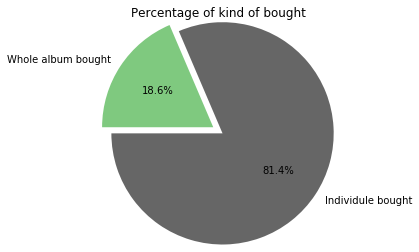

In [19]:
ax0=plt.axes()
per_inv.plot.pie(colormap=plt.cm.Accent,
                 title='Percentage of kind of bought',
                 counterclock=False,
                 wedgeprops={'linewidth':0},
                 fontsize=10,
                 explode=(0,0.1),
                 startangle=-180,
                 ax=ax0,
                 autopct='%1.1f%%'
                )
ax0.axis('equal')
ax0.set_ylabel('')

As we can see, the whole album bought invoices only domain a 18.6% in total invoices. It seems that it is a good idea to buy the most popular songs in each album compared with just buy the whole album.However, to draw this conclusion,maybe we need to find the total of sales with the two kinds bought strategy.